In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

% matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 8.0)
pd.set_option('display.precision',9)

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [ ]:
#df_prophet = pd.read_csv('./bw_cleaned_data.csv')
#df_prophet = df_prophet[df_prophet.loc[:, 'ts'] != 'ts']
#df_prophet.loc[:, 'bandwidth'] = pd.to_numeric(df_prophet.loc[:, 'bandwidth'], errors='coerce')
#df_prophet['ts'] = pd.to_datetime(df_prophet['ts'], utc=True)
#df_prophet.rename(columns={'bandwidth': 'y', 'ts': 'ds'}, inplace=True)
##df_prophet.set_index('ds', inplace=True)
##df_prophet.sort_index(inplace=True)df_prophet.head()

In [2]:
df_prophet = pd.read_csv('./bw_data.csv')
df_prophet.drop(columns=['id'], inplace=True)
#df.drop(columns=['id'], inplace=True)
df_prophet = df_prophet[df_prophet.loc[:, 'ts'] != 'ts']
df_prophet.loc[:, 'bandwidth'] = pd.to_numeric(df_prophet.loc[:, 'bandwidth'], errors='coerce')
df_prophet['ts'] = pd.to_datetime(df_prophet['ts'], unit='s', utc=True)
df_prophet.rename(columns={'bandwidth': 'y', 'ts': 'ds'}, inplace=True)


In [3]:
df_prophet.reset_index(inplace=True)
df_prophet.set_index('ds', inplace=True)
df_prophet.sort_index(inplace=True)
df_prophet = df_prophet[(df_prophet.index.day > 6) & (df_prophet.index.day <= 7) & (df_prophet.index.month == 2)]
df_prophet.reset_index(inplace=True)

dates = df_prophet['ds']
df_prophet.loc[:, 'ds'] = dates.dt.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
df_prophet.head()

,ds,index,y
0,2018-02-07 00:00:00,769460,354146208
1,2018-02-07 00:00:01,768952,151009688
2,2018-02-07 00:00:02,770906,115239480
3,2018-02-07 00:00:03,770713,88881008
4,2018-02-07 00:00:04,770217,66831624


In [5]:
df_prophet.drop('index', axis=1, inplace=True)

In [6]:
size = int(len(df_prophet) * 0.67)
train, test = df_prophet.iloc[0:size, :], df_prophet.iloc[size:len(df_prophet), :]

In [7]:
from fbprophet import Prophet

m = Prophet(daily_seasonality=True, seasonality_prior_scale=0.1)
m.fit(train)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [8]:
future = m.make_future_dataframe(periods=len(test), freq='S', include_history=True)

In [9]:
forecast_data = m.predict(future)

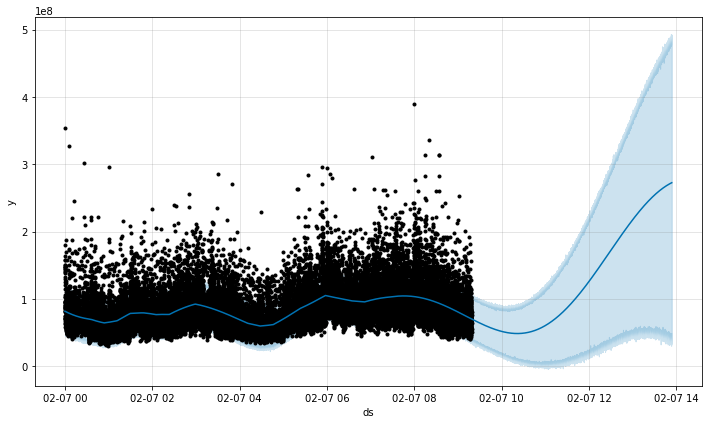

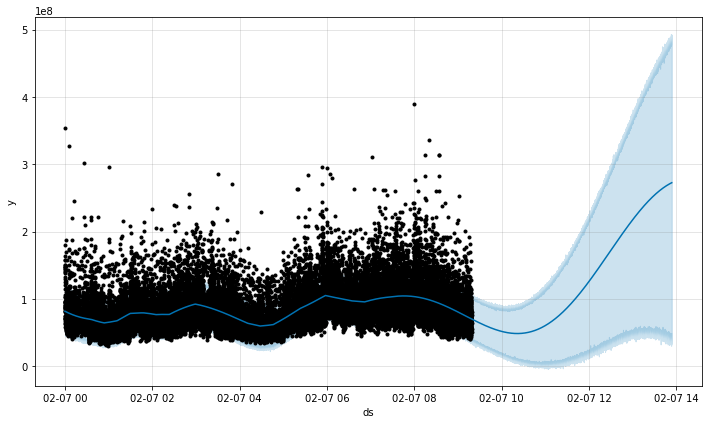

In [10]:
m.plot(forecast_data)

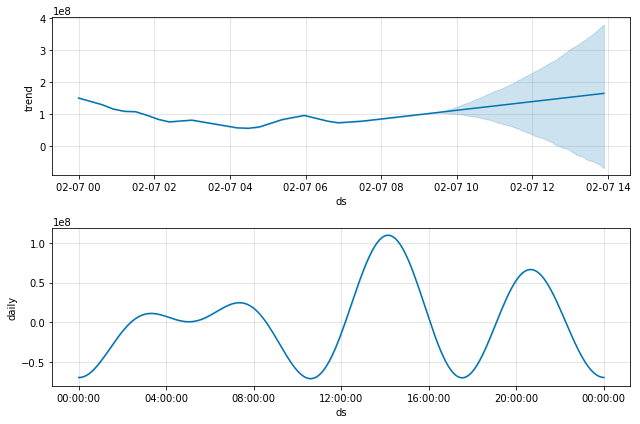

In [11]:
fig = m.plot_components(forecast_data)

In [28]:
forecast_data[['yhat', 'yhat_lower', 'yhat_upper']].tail()

,yhat,yhat_lower,yhat_upper
ds,,,
2018-02-07 13:53:30,2.725538978e+08,4.762303931e+07,4.852989832e+08
2018-02-07 13:53:31,2.725628905e+08,4.043356494e+07,4.895592351e+08
2018-02-07 13:53:32,2.725718774e+08,3.861427053e+07,4.871985332e+08
2018-02-07 13:53:33,2.725808585e+08,3.936569019e+07,4.817895924e+08
2018-02-07 13:53:34,2.725898339e+08,4.508092729e+07,4.849756251e+08


In [13]:
df_prophet.set_index('ds', inplace=True)
forecast_data.set_index('ds', inplace=True)

In [14]:
viz_df = df_prophet.join(forecast_data[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [56]:
viz_df.tail()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-02-07 13:55:14,88974856.0,NaN,NaN,NaN
2018-02-07 13:55:15,95518584.0,NaN,NaN,NaN
2018-02-07 13:55:16,119129672.0,NaN,NaN,NaN
2018-02-07 13:55:18,82732328.0,NaN,NaN,NaN
2018-02-07 13:55:19,99631272.0,NaN,NaN,NaN


In [54]:
from datetime import date,timedelta

def plot_data(func_df, test_index):
    predict_df = func_df.iloc[test_index:, :] # using the mask, we create a new dataframe with just the predicted data.
    print(predict_df.head())
    
# Now...plot everything
    fig, ax1 = plt.subplots()
    ax1.plot(df_prophet.y)
    ax1.plot(predict_df.yhat, color='black', linestyle=':')
    ax1.fill_between(predict_df.index, predict_df['yhat_upper'], predict_df['yhat_lower'], alpha=0.5, color='darkgray')
    ax1.set_title('Bandwidth (Blue) vs Bandwidth Forecast (Red)')
    ax1.set_ylabel('Bandwidth')
    ax1.set_xlabel('Date')
  
# change the legend text
    L=ax1.legend() #get the legend
    L.get_texts()[0].set_text('Actual Bandwidth') #change the legend text for 1st plot
    L.get_texts()[1].set_text('Forecasted Bandwidth') #change the legend text for 2nd plot

                              y             yhat       yhat_lower  \
ds                                                                  
2018-02-07 09:18:35  65871048.0  7.015406541e+07  3.710302174e+07   
2018-02-07 09:18:36  50589304.0  7.014488511e+07  3.813805180e+07   
2018-02-07 09:18:37  64980568.0  7.013570533e+07  3.725381715e+07   
2018-02-07 09:18:38  68410680.0  7.012652606e+07  3.588913311e+07   
2018-02-07 09:18:39  59781064.0  7.011734732e+07  3.678174811e+07   

                          yhat_upper  
ds                                    
2018-02-07 09:18:35  1.044190799e+08  
2018-02-07 09:18:36  1.018228669e+08  
2018-02-07 09:18:37  1.020463132e+08  
2018-02-07 09:18:38  1.015662940e+08  
2018-02-07 09:18:39  1.026431569e+08  


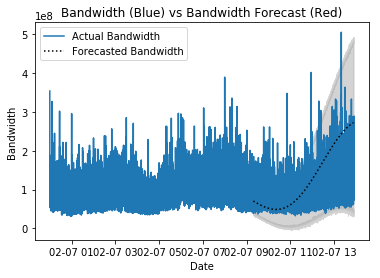

In [55]:
plot_data(viz_df, test.index[0])